In [33]:
# Library imports
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import set_config

In [22]:
# Loading dataset
df = pd.read_csv('hour.csv')
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [23]:
df['day_night'] = df['hr'].apply(lambda x: 'day' if 6 <= x <= 18 else 'night')
df.drop(['instant', 'casual', 'registered'], axis=1, inplace=True)
df['dteday'] = pd.to_datetime(df.dteday)
df['season'] = df.season.astype('category')
df['holiday'] = df.holiday.astype('category')
df['weekday'] = df.weekday.astype('category')
df['weathersit'] = df.weathersit.astype('category')
df['workingday'] = df.workingday.astype('category')
df['mnth'] = df.mnth.astype('category')
df['yr'] = df.yr.astype('category')
df['hr'] = df.hr.astype('category')
df.drop(columns=['dteday'], inplace=True)
# Separating features and target variable
X = df.drop(columns=['cnt']) # Features
y = df['cnt'] # Target

In [25]:
# Numerical features
numerical_features = ['temp', 'hum', 'windspeed']
numerical_pipeline = Pipeline([
('imputer', SimpleImputer(strategy='mean')), # Impute missing values with mean
('scaler', MinMaxScaler()) # Normalize using MinMaxScaler
])
# Transforming above
X[numerical_features] = numerical_pipeline.fit_transform(X[numerical_features])
# Categorical features
categorical_features = ['season', 'weathersit', 'day_night']
categorical_pipeline = Pipeline([
('imputer', SimpleImputer(strategy='most_frequent')),
('onehot', OneHotEncoder(sparse_output=False, drop='first'))
])
# Transforming above
X_encoded = categorical_pipeline.fit_transform(X[categorical_features])
# Converting it to a dataframe
X_encoded = pd.DataFrame(X_encoded,
columns=categorical_pipeline.named_steps['onehot'].get_feature_names_out(categorical_features))
# Encoded categorical features + Numerical features
X = pd.concat([X.drop(columns=categorical_features), X_encoded], axis=1)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

<Axes: >

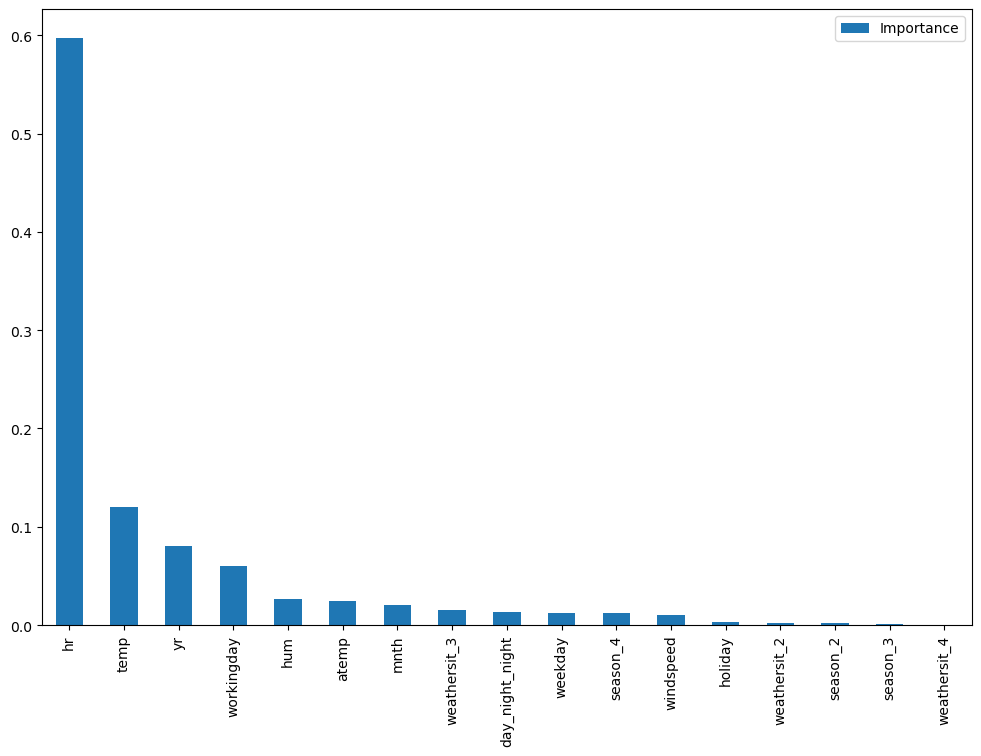

In [30]:
feat_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
# Plotting each feature importance
feat_importances.plot(kind='bar', figsize=(12,8))

In [31]:
# Predictions
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 1808.4074990292243
R-squared: 0.9428901308176855


In [34]:
final_pipeline = Pipeline([
('num_preprocess', numerical_pipeline),
('cat_preprocess', categorical_pipeline),
('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

set_config(display='diagram')# To display
final_pipeline

Pipeline(steps=[('num_preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('cat_preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('onehot',
                                  OneHotEncoder(drop='first',
                                                sparse_output=False))])),
                ('model', RandomForestRegressor(random_state=42))])